In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pytearcat as pt

In [2]:
# Define coordinates and metric
tau, x, y, z = pt.coords('tau,x,y,z')
a = pt.fun('a', 'tau')
Phi = pt.fun('Phi', 'x,y,z')
ds2 = 'ds2 = a**2*(-(1 + 2*Phi)*dtau**2 + (1 - 2*Phi)*(dx**2 + dy**2 + dz**2))'
g = pt.metric(ds2)

Remember that the time coordinate must be the first coordinate.

Dimension = 4
Coordinates = tau,x,y,z
Metric defined successfully: 



<IPython.core.display.Math object>

Matrix([
[-2*Phi(x, y, z)*a(tau)**2 - a(tau)**2,                                     0,                                     0,                                     0],
[                                    0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2,                                     0,                                     0],
[                                    0,                                     0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2,                                     0],
[                                    0,                                     0,                                     0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2]])

In [3]:
# To calculate the second kind without the first kind: 
Chr = pt.christoffel(First_kind = False)  
# To display only a particular combination of indices, e.g., the Second kind: 
Chr.display("^,_,_")

<IPython.core.display.Latex object>

  0%|          | 0/64 [00:00<?, ?it/s]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Define potential and derivatives
m = 0.06  # Reduced mass for weak-field approximation

def phi(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return -m / r if r > 1e-10 else 0

def dphi_dx(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    val = m * x / r**3 if r > 1e-10 else 0
    return np.clip(val, -1, 1)  # Clip to prevent numerical issues

def dphi_dy(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    val = m * y / r**3 if r > 1e-10 else 0
    return np.clip(val, -1, 1)

def dphi_dz(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    val = m * z / r**3 if r > 1e-10 else 0
    return np.clip(val, -1, 1)

In [5]:
# Set initial conditions
beta = np.pi / 2
alpha = 0.0
tau0 = 0.0
x0 = 50.0
y0 = 1.0  # Reduced for stronger lensing
z0 = 1.0  # Reduced for stronger lensing
a0 = 1.0

phi0 = phi(x0, y0, z0)
g00_0 = -a0**2 * (1.0 + 2.0 * phi0)
g11_0 = a0**2 * (1.0 - 2.0 * phi0)
g22_0 = a0**2 * (1.0 - 2.0 * phi0)
g33_0 = a0**2 * (1.0 - 2.0 * phi0)

ktau_0 = 1.0 / np.sqrt(np.abs(g00_0))
kx_0 = np.cos(alpha) * np.sin(beta) / np.sqrt(np.abs(g11_0))
ky_0 = np.sin(alpha) * np.sin(beta) / np.sqrt(np.abs(g22_0))
kz_0 = np.cos(beta) / np.sqrt(np.abs(g33_0))

h0 = [tau0, ktau_0, x0, kx_0, y0, ky_0, z0, kz_0, a0]

In [6]:
# Cosmological parameters
wm = 0.3
wd = 0.7
H0 = 0.070894407 * 3.26 / (1000 * 0.67556)

In [7]:
# Define the geodesic function
def geodesic(l, h):
    tau, ktau, x, kx, y, ky, z, kz, a = h

    dadtau = H0 * a**2 * np.sqrt(wm / a**3 + wd)
    phi_val = phi(x, y, z)
    dphi_dx_val = dphi_dx(x, y, z)
    dphi_dy_val = dphi_dy(x, y, z)
    dphi_dz_val = dphi_dz(x, y, z)

    den1 = 1.0 + 2.0 * phi_val
    den2 = 1.0 - 2.0 * phi_val

    # Debug: Check for potential numerical issues
    if den1 < 0 or den2 < 0 or abs(phi_val) > 0.1:
        print(f"Warning at λ={l}: |Phi|={abs(phi_val):.2e}, den1={den1:.2e}, den2={den2:.2e}")

    gamma_000 = dadtau / a
    gamma_001 = dphi_dx_val / den1
    gamma_002 = dphi_dy_val / den1
    gamma_003 = dphi_dz_val / den1
    gamma_010 = gamma_001
    gamma_020 = gamma_002
    gamma_030 = gamma_003
    gamma_011 = (dadtau / a) * (den2 / den1)
    gamma_022 = gamma_011
    gamma_033 = gamma_011

    gamma_100 = dphi_dx_val / den2
    gamma_101 = dadtau / a
    gamma_110 = gamma_101
    gamma_111 = -dphi_dx_val / den2
    gamma_112 = -dphi_dy_val / den2
    gamma_113 = -dphi_dz_val / den2
    gamma_121 = gamma_112
    gamma_122 = dphi_dx_val / den2
    gamma_131 = gamma_113
    gamma_133 = dphi_dx_val / den2

    gamma_200 = dphi_dy_val / den2
    gamma_202 = dadtau / a
    gamma_220 = gamma_202
    gamma_211 = dphi_dy_val / den2
    gamma_212 = -dphi_dx_val / den2
    gamma_221 = gamma_212
    gamma_222 = -dphi_dy_val / den2
    gamma_223 = -dphi_dz_val / den2
    gamma_232 = gamma_223
    gamma_233 = dphi_dy_val / den2

    gamma_300 = dphi_dz_val / den2
    gamma_303 = dadtau / a
    gamma_330 = gamma_303
    gamma_311 = dphi_dz_val / den2
    gamma_313 = -dphi_dx_val / den2
    gamma_322 = dphi_dz_val / den2
    gamma_323 = -dphi_dy_val / den2
    gamma_331 = gamma_313
    gamma_332 = gamma_323
    gamma_333 = -dphi_dz_val / den2

    dhdl = [
        ktau,
        -(gamma_000 * ktau**2 + 2 * gamma_001 * ktau * kx + 2 * gamma_002 * ktau * ky + 2 * gamma_003 * ktau * kz +
          gamma_011 * kx**2 + gamma_022 * ky**2 + gamma_033 * kz**2),
        kx,
        -(gamma_100 * ktau**2 + 2 * gamma_101 * ktau * kx + 2 * gamma_112 * kx * ky + 2 * gamma_113 * kx * kz +
          gamma_111 * kx**2 + gamma_122 * ky**2 + gamma_133 * kz**2),
        ky,
        -(gamma_200 * ktau**2 + 2 * gamma_202 * ktau * ky + 2 * gamma_212 * ky * kx + 2 * gamma_223 * ky * kz +
          gamma_211 * kx**2 + gamma_222 * ky**2 + gamma_233 * kz**2),
        kz,
        -(gamma_300 * ktau**2 + 2 * gamma_303 * ktau * kz + 2 * gamma_313 * kz * kx + 2 * gamma_323 * kz * ky +
          gamma_311 * kx**2 + gamma_322 * ky**2 + gamma_333 * kz**2),
        dadtau * ktau
    ]
    return dhdl

In [8]:
# Affine parameter
l = np.linspace(0, -500, 60000)  # Increased resolution for smoother plots

# Integrate
sol = solve_ivp(geodesic, [0, -500], h0, method='LSODA', rtol=1e-13, atol=1e-15, t_eval=l, max_step=0.05)

tau, ktau, x, kx, y, ky, z, kz, a = sol.y

In [9]:
# Compute metric components
phi_vals = np.array([phi(x[i], y[i], z[i]) for i in range(len(l))])
g00 = -a**2 * (1 + 2 * phi_vals)
g11 = a**2 * (1 - 2 * phi_vals)
g22 = a**2 * (1 - 2 * phi_vals)
g33 = a**2 * (1 - 2 * phi_vals)

# Null condition with underflow protection
null_condition = g00 * ktau**2 + g11 * kx**2 + g22 * ky**2 + g33 * kz**2
if np.any(null_condition < 0):
    neg_indices = np.where(null_condition < 0)[0]
    print(f"Warning: Negative null condition detected at {len(neg_indices)} points, e.g., λ={l[neg_indices[:5]]}")


In [10]:
# Energy and redshift
E = ktau
redshift = (E * a) / (ktau[0] * a[0]) - 1  # Normalized redshift

In [11]:
# Deflection angle (in XY plane)
initial_angle = np.arctan2(ky[0], kx[0]) * 180 / np.pi  # degrees
final_angle = np.arctan2(ky[-1], kx[-1]) * 180 / np.pi  # degrees
deflection_angle = final_angle - initial_angle
deflection_vs_lambda = np.arctan2(ky, kx) * 180 / np.pi - initial_angle

In [ ]:
# Reference straight-line trajectory (no lensing, for comparison)
x_straight = x0 + l * kx_0 * np.sqrt(np.abs(g11_0))  # Approximate straight path
y_straight = y0 + l * ky_0 * np.sqrt(np.abs(g22_0))
z_straight = z0 + l * kz_0 * np.sqrt(np.abs(g33_0))

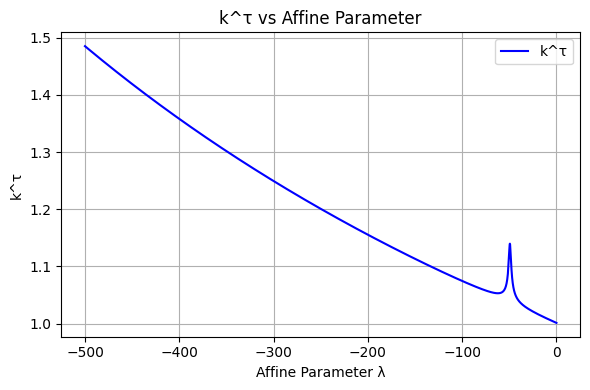

In [13]:
# Diagnostic: Plot k^τ
plt.figure(figsize=(6, 4))
plt.plot(l, ktau, 'b-', label='k^τ')
plt.xlabel('Affine Parameter λ')
plt.ylabel('k^τ')
plt.title('k^τ vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

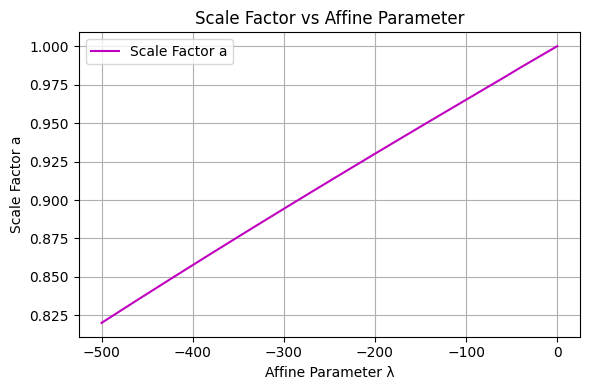

In [14]:
# Diagnostic: Plot scale factor
plt.figure(figsize=(6, 4))
plt.plot(l, a, 'm-', label='Scale Factor a')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Scale Factor a')
plt.title('Scale Factor vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

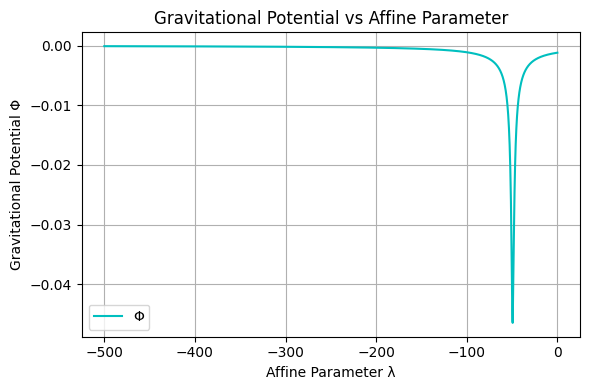

In [15]:
# Diagnostic: Plot gravitational potential
plt.figure(figsize=(6, 4))
plt.plot(l, phi_vals, 'c-', label='Φ')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Gravitational Potential Φ')
plt.title('Gravitational Potential vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

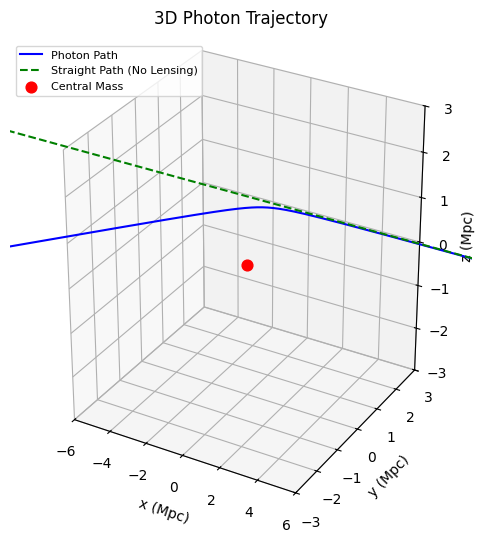

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, color='blue', label='Photon Path')
ax.plot(x_straight, y_straight, z_straight, color='green', linestyle='--',
        label='Straight Path (No Lensing)')
ax.scatter([0], [0], [0], color='red', s=60, label='Central Mass')

ax.set_xlabel('x (Mpc)')
ax.set_ylabel('y (Mpc)')
ax.set_zlabel('z (Mpc)')
ax.set_xlim([-6, 6])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])
ax.set_box_aspect([1, 1, 1.2])  
ax.set_title('3D Photon Trajectory', pad=12)
ax.legend(fontsize=8, loc="upper left")

# plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.show()

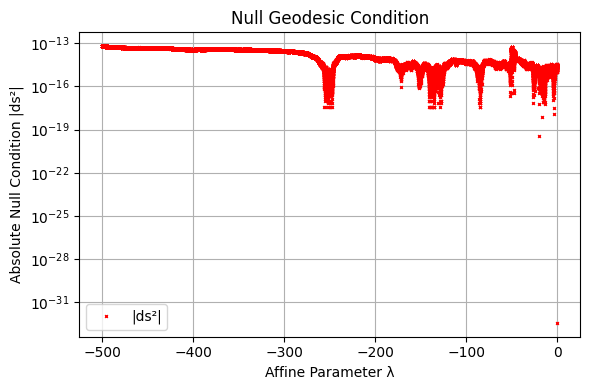

In [17]:
# Null condition plot
plt.figure(figsize=(6, 4))
plt.plot(l, np.abs(null_condition), 'rx', markersize=2, label='|ds²|')
plt.yscale('log')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Absolute Null Condition |ds²|')
plt.title('Null Geodesic Condition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

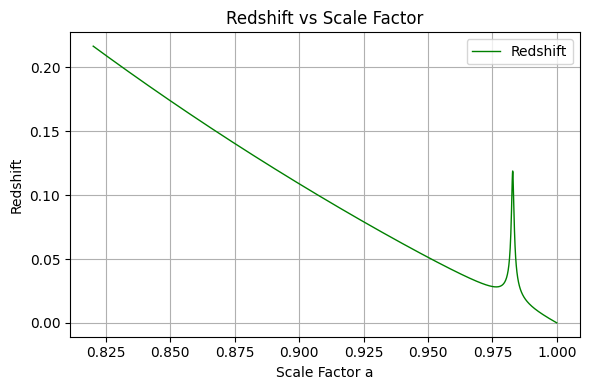

In [18]:
# Redshift plot
plt.figure(figsize=(6, 4))
plt.plot(a, redshift, 'g-', linewidth=1, label='Redshift')
plt.xlabel('Scale Factor a')
plt.ylabel('Redshift')
plt.title('Redshift vs Scale Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

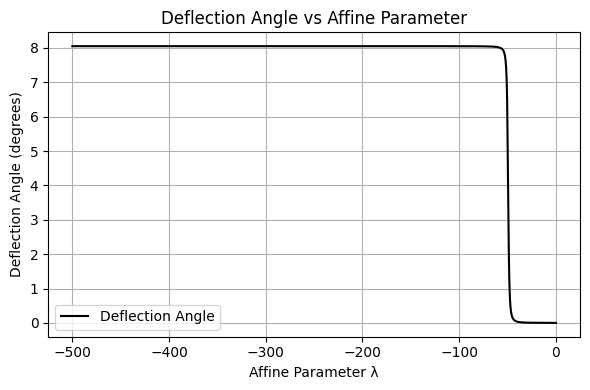

In [19]:
# Deflection angle vs λ
plt.figure(figsize=(6, 4))
plt.plot(l, deflection_vs_lambda, 'k-', label='Deflection Angle')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Deflection Angle (degrees)')
plt.title('Deflection Angle vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

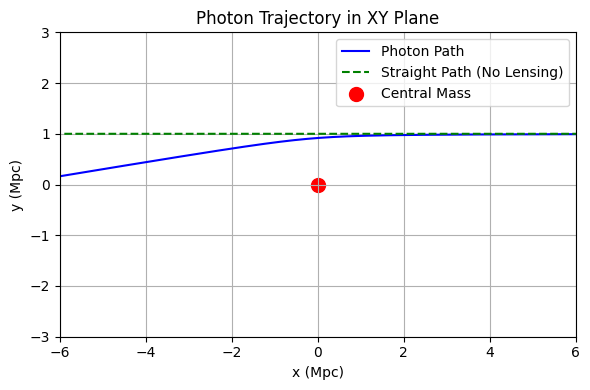

In [20]:
# XY plane trajectory
plt.figure(figsize=(6, 4))
plt.plot(x, y, color='blue', label='Photon Path')
plt.plot(x_straight, y_straight, color='green', linestyle='--', label='Straight Path (No Lensing)')
plt.scatter([0], [0], color='red', s=100, label='Central Mass')
plt.xlabel('x (Mpc)')
plt.ylabel('y (Mpc)')
plt.title('Photon Trajectory in XY Plane')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.xlim(-6, 6)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

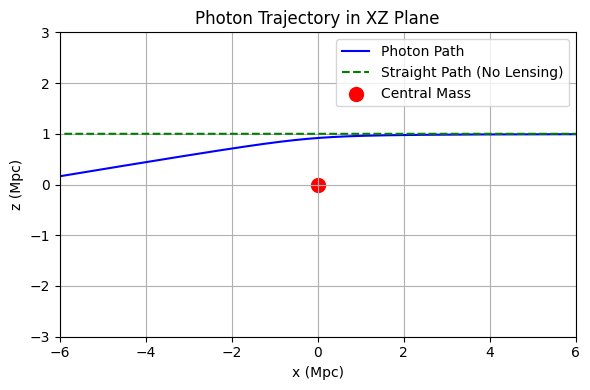

In [21]:
# XZ plane trajectory
plt.figure(figsize=(6, 4))
plt.plot(x, z, color='blue', label='Photon Path')
plt.plot(x_straight, z_straight, color='green', linestyle='--', label='Straight Path (No Lensing)')
plt.scatter([0], [0], color='red', s=100, label='Central Mass')
plt.xlabel('x (Mpc)')
plt.ylabel('z (Mpc)')
plt.title('Photon Trajectory in XZ Plane')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.xlim(-6, 6)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()


In [22]:
# Diagnostics section
print("=== NULL GEODESIC DIAGNOSTICS ===")
print(f"Initial null condition: {null_condition[0]:.2e}")
print(f"Final null condition: {null_condition[-1]:.2e}")
print(f"Average null condition: {np.nanmean(null_condition):.2e}")
print(f"Minimum absolute null condition: {np.min(np.abs(null_condition)[np.abs(null_condition) > 1e-100]):.2e}")
print(f"Maximum absolute null condition: {np.nanmax(np.abs(null_condition)):.2e}")
print(f"Standard deviation of null condition: {np.nanstd(null_condition):.2e}")
print(f"Maximum absolute potential |Phi|: {np.nanmax(np.abs(phi_vals)):.6f}")
print(f"Initial redshift: {redshift[0]:.6f}")
print(f"Final redshift: {redshift[-1]:.6f}")
print(f"Scale factor change: {sol.y[8][0]:.6f} → {sol.y[8][-1]:.6f}")
print(f"Time coordinate change: {sol.y[0][0]:.2f} → {sol.y[0][-1]:.2f}")
print(f"Minimum distance to origin: {np.min(np.sqrt(x**2 + y**2 + z**2)):.6f}")
print(f"Deflection angle (degrees): {deflection_angle:.6f}")
print(f"Integration steps taken: {sol.nfev}")
print(f"Integration status: {sol.message}")

=== NULL GEODESIC DIAGNOSTICS ===
Initial null condition: 3.75e-33
Final null condition: 6.18e-14
Average null condition: 1.70e-14
Minimum absolute null condition: 3.75e-33
Maximum absolute null condition: 6.28e-14
Standard deviation of null condition: 2.22e-14
Maximum absolute potential |Phi|: 0.046458
Initial redshift: 0.000000
Final redshift: 0.216657
Scale factor change: 1.000000 → 0.820129
Time coordinate change: 0.00 → -608.32
Minimum distance to origin: 1.291483
Deflection angle (degrees): 8.053107
Integration steps taken: 10248
Integration status: The solver successfully reached the end of the integration interval.
